##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

In [2]:
!pip install pandas
!pip install tensorflow
!pip install tensorflow_datasets
!pip install panda

In [3]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds
import my_dataset_dataset_builder

import datetime

%load_ext tensorboard
%load_ext autoreload
%autoreload 2

2023-09-19 16:15:18.099360: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Download the classifier

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model [from TensorFlow Hub](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) and wrap it as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Any <a href="https://tfhub.dev/s?q=tf2&module-type=image-classification/" class="external">compatible image classifier model</a> from TensorFlow Hub will work here, including the examples provided in the drop-down below.

In [4]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [44]:
BATCH_SIZE = 32
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,), trainable=False)
])

classifier.add(tf.keras.layers.Dense(6,activation="sigmoid"))

### Run it on a single image

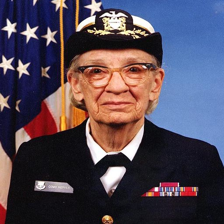

In [6]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_SHAPE))
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension (with `np.newaxis`) and pass the image to the model:

In [8]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

2023-09-19 16:15:23.265857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


1/1 [==============================] - 1s 1s/step


(1, 1001)

The result is a 1001-element vector of logits, rating the probability of each class for the image.

The top class ID can be found with `tf.math.argmax`:

In [9]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

### Decode the prediction

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

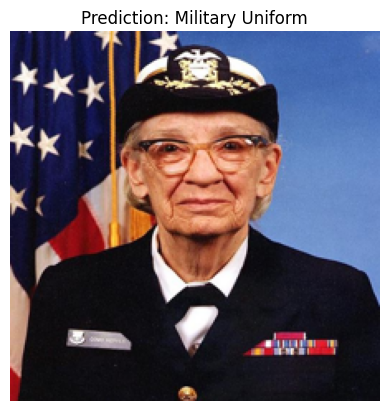

In [11]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset

In [12]:
ds_split, ds_info = tfds.load("MyDatasetBuilder", split=['train[:20%]', 'train[20%:]'], with_info=True, as_supervised=True,)

val_ds = ds_split[0]
train_ds = ds_split[1]

print(ds_info.features)
df_test = tfds.as_dataframe(val_ds.take(10), ds_info)
print("Test dataset sample: ")
print(df_test)

#df_train = tfds.as_dataframe(train_ds.take(10), ds_info)
#print("Train dataset sample: ")
#print(df_train)

#ds_train_batch = train_ds.batch(32)

FeaturesDict({
    'detections': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=6),
    }),
    'image': Image(shape=(None, None, 3), dtype=uint8),
})


2023-09-19 16:15:33.374952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]
2023-09-19 16:15:33.375476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [2]
	 [[{{node Placeholder/_4}}]]
2023-09-19 16:15:36.411020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-19 16:15:36.411238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


Test dataset sample: 
                                     detections/bbox  \
0  [[[0.556, 0.57, 0.7, 0.633], [0.521, 0.79, 0.6...   
1  [[[0.19824219, 0.16510417, 0.7199219, 0.805208...   
2  [[[0.15625, 0.20625, 0.9140625, 0.746875], [0....   
3  [[[0.3046875, 0.3578125, 0.9671875, 0.809375],...   
4  [[[0.29375, 0.309375, 0.81875, 0.75625], [0.0,...   
5  [[[0.0, 0.001998002, 0.994003, 0.9120879], [0....   
6  [[[0.12444445, 0.093333334, 0.9866667, 0.92888...   
7  [[[0.059333332, 0.141, 1.0, 0.6565], [0.0, 0.0...   
8  [[[0.3046875, 0.2125, 0.5953125, 0.68125], [0....   
9  [[[0.5796875, 0.0953125, 0.9953125, 0.3328125]...   

                                    detections/label  \
0  [[1, 3], [2, 0], [0, 0], [1, 0], [4, 0], [0, 0...   
1  [[1, 0], [2, 0], [0, 0], [0, 0], [1, 0], [0, 0...   
2  [[2, 0, 0], [4, 0, 0], [4, 0, 0], [4, 0, 0], [...   
3  [[2, 0, 0], [1, 1, 0], [4, 0, 0], [3, 3, 0], [...   
4  [[4, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...   
5  [[1, 0], [4, 0], [1, 0

In [13]:
print(np.array(ds_info.features['detections']['label'].names))

['handbag' 'suitcase' 'stroller' 'backpack' 'golf_club' 'duffel_bag']


In [14]:
print(len(train_ds) + len(val_ds))

75


In [15]:
train_ds = train_ds.map(lambda x,z: (tf.image.resize(x, (224,224)),z))
val_ds = val_ds.map(lambda x,z: (tf.image.resize(x, (224,224)),z))

In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x,y: (normalization_layer(x),y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x,y: (normalization_layer(x),y)) # Where x—images, y—labels.

Third, finish the input pipeline by using buffered prefetching with `Dataset.prefetch`, so you can yield the data from disk without I/O blocking issues.

These are some of the most important `tf.data` methods you should use when loading data. Interested readers can learn more about them, as well as how to cache data to disk and other techniques, in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance#prefetching) guide.

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_rn.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_rn.cache().prefetch(buffer_size=AUTOTUNE)

### Run the classifier on a batch of images

Now, run the classifier on an image batch:

In [18]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), {'bbox': TensorSpec(shape=(None, None, 4), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)})>


In [45]:
result_batch = classifier.predict(train_ds)

60/60 [==============================] - 2s 20ms/step


In [29]:
luggage_labels = np.array(['handbag', 'suitcase', 'stroller', 'backpack', 'golf_club', 'duffel_bag',])

In [46]:
predicted_class_names = luggage_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['duffel_bag', 'duffel_bag', 'golf_club', ..., 'stroller',
       'duffel_bag', 'golf_club'], dtype='<U10')

In [47]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    break

(32, 224, 224, 3)


Check how these predictions line up with the images:

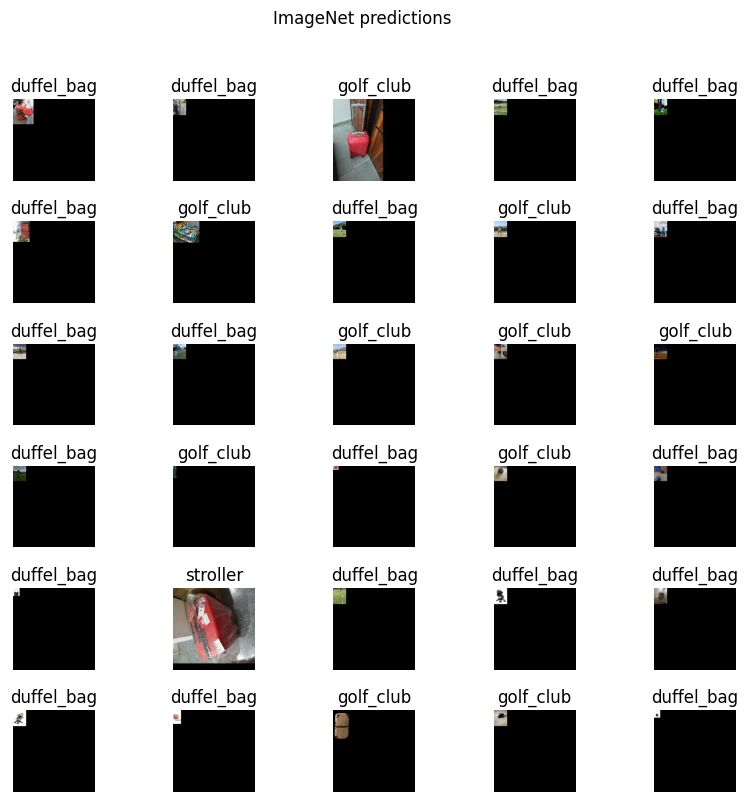

In [48]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except for "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">from TensorFlow Hub</a>. Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In [65]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
detector = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

detector_model = detector

Create the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [66]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

detector_layer = hub.KerasLayer(
    detector_model,
    input_shape=(224,224,3),
    trainable=False,
    output_key="detection_classes"
)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):

In [53]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [ ]:
print(feature_extractor_layer.)

### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [59]:
num_classes = len(luggage_labels)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes, activation="sigmoid")
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [60]:
predictions = model(image_batch)

In [61]:
predictions.shape

TensorShape([32, 6])

### Train the model

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [62]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

Now use the `Model.fit` method to train the model.

To keep this example short, you'll be training for just 10 epochs. To visualize the training progress in TensorBoard later, create and store logs an a [TensorBoard callback](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit).

In [63]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/compile_utils.py", line 236, in __call__
        y_true = self._conform_to_outputs(y_pred, y_true)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/compile_utils.py", line 60, in _conform_to_outputs
        struct = map_to_output_names(outputs, self._output_names, struct)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/compile_utils.py", line 805, in map_to_output_names
        raise ValueError(

    ValueError: Found unexpected losses or metrics that do not correspond to any Model output: dict_keys(['bbox', 'label']). Valid mode output names: ['dense_4']. Received struct is: {'bbox': <tf.Tensor 'IteratorGetNext:1' shape=(None, None, 4) dtype=float32>, 'label': <tf.Tensor 'IteratorGetNext:2' shape=(None, None) dtype=int64>}.


Start the TensorBoard to view how the metrics change with each epoch and to track other scalar values:

In [ ]:
%tensorboard --logdir logs/fit

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

### Check the predictions

Obtain the ordered list of class names from the model predictions:

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

Plot the model predictions:

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export and reload your model

Now that you've trained the model, export it as a SavedModel for reusing it later.

In [ ]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

Confirm that you can reload the SavedModel and that the model is able to output the same results:

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()

In [ ]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Next steps

You can use the SavedModel to load for inference or convert it to a [TensorFlow Lite](https://www.tensorflow.org/lite/models/convert/)  model (for on-device machine learning) or a [TensorFlow.js](https://www.tensorflow.org/js/tutorials#convert_pretrained_models_to_tensorflowjs) model (for machine learning in JavaScript).

Discover [more tutorials](https://www.tensorflow.org/hub/tutorials) to learn how to use pre-trained models from TensorFlow Hub on image, text, audio, and video tasks.